# Notebook 00: Data-Driven Specialty Taxonomy

## 🎯 What This Notebook Does

**Goal:** Transform 5,126 fine-grained `focus_area` labels into ~15-20 high-level medical specialties using embeddings + clustering.

**Why?** The raw dataset has too many categories (5,126) with too few examples each (most < 10 samples). This makes classification impossible. By grouping related conditions into medical specialties (Oncology, Cardiology, etc.), we create a manageable multi-class problem.

**Approach:** Bottom-up, data-driven taxonomy construction:
1. **Embed** `focus_area` strings → semantic vectors (using BioBERT)
2. **Cluster** vectors → discover natural groupings
3. **Inspect** clusters → assign human-interpretable specialty labels
4. **Validate** with zero-shot classification
5. **Export** mapping + labeled dataframe

**End Product:** A new column `df["specialty"]` with ~15-20 balanced medical categories.

---

## 📋 Key Phases

1. ✅ Project setup & data loading
2. ✅ Deduplicate focus_area catalog
3. ✅ Embed focus_areas with BioBERT
4. ✅ Dimensionality reduction (UMAP) for visualization
5. ✅ Cluster with HDBSCAN + k-means
6. ✅ Inspect clusters & assign specialty names
7. ✅ Validate with zero-shot classification
8. ✅ Merge back to full dataframe
9. ✅ Export final taxonomy

---

## ✅ Acceptance Criteria

- [ ] Created 15-20 medical specialties from 5,126 focus_areas
- [ ] Each specialty has ≥50 samples (ideally ≥100)
- [ ] Clusters are semantically coherent (validated by inspection + zero-shot)
- [ ] Exported: `df_with_specialty.parquet` + `focus_area_to_specialty.json`
- [ ] Documented: Clustering params, model choices, manual decisions

## 🔧 Setup: Project Paths & Environment

**TODO 1:** Configure paths and create output directories.

**Hints:**
- Point to your MedQuad CSV (likely in `../../../datasets/medquad.csv`)
- Create an artifacts folder to save embeddings, clusters, and mappings
- Use `pathlib.Path` for cross-platform compatibility

In [16]:
# TODO 1: Set up project paths & environment

from pathlib import Path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
DATA_DIR = Path("../../../datasets")
INPUT_PATH = DATA_DIR / "medquad.csv"
ARTIFACTS_DIR = Path("../artifacts/specialty_taxonomy")

# Create output directory
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Input data: {INPUT_PATH}")
print(f"✅ Artifacts will be saved to: {ARTIFACTS_DIR}")

✅ Input data: ../../../datasets/medquad.csv
✅ Artifacts will be saved to: ../artifacts/specialty_taxonomy


## 📊 Load Data & Basic EDA

**TODO 2:** Load the MedQuad dataset and perform basic checks.

**What to check:**
- Dataset shape and columns
- Presence of , , 
- Number of unique focus_areas
- Top 20 most frequent focus_areas
- Any missing values

**Hints:**
- Create a normalized version of  (strip whitespace, handle case)
- Keep  and  for later sanity checks

In [17]:
# TODO 2: Load data & basic EDA

# Load dataframe
df = pd.read_csv(INPUT_PATH)

# Basic info
print("Dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nFirst few rows:")
# display(df.head())

# Check for required columns
required_cols = ['focus_area', 'question', 'answer']
assert all(col in df.columns for col in required_cols), f"Missing columns! Need: {required_cols}"

# Normalize focus_area for consistency
df['focus_area_norm'] = df['focus_area'].str.strip().str.lower()
display(df.head())
# Remove any rows with missing focus_area
df = df.dropna(subset=['focus_area_norm'])
print(f"\n✅ After removing NaN focus_areas: {df.shape[0]} rows")

# Unique focus_areas
n_unique = df['focus_area_norm'].nunique()
print(f"\n📊 Number of unique focus_areas: {n_unique}")

# Top 20 most common
print("\nTop 20 most frequent focus_areas:")
print(df['focus_area_norm'].value_counts().head(20))

Dataset shape: (16412, 4)

Columns: ['question', 'answer', 'source', 'focus_area']

First few rows:


,question,answer,source,focus_area,focus_area_norm
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma,glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma,glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma



✅ After removing NaN focus_areas: 16398 rows

📊 Number of unique focus_areas: 4742

Top 20 most frequent focus_areas:
focus_area_norm
breast cancer                       58
prostate cancer                     48
stroke                              35
skin cancer                         34
lung cancer                         34
alzheimer's disease                 30
colorectal cancer                   29
heart attack                        28
high blood cholesterol              28
heart failure                       28
causes of diabetes                  28
high blood pressure                 27
age-related macular degeneration    25
wilson disease                      25
parkinson's disease                 25
leukemia                            22
shingles                            21
osteoporosis                        21
polycythemia vera                   20
hemochromatosis                     20
Name: count, dtype: int64


## 🗂️ Build Unique Focus_Area Catalog

**TODO 3:** Create a catalog of unique focus_areas with their counts.

**Why deduplicate?**
- Clustering 5,126 unique strings is much faster than clustering 16,412 rows
- Avoids over-weighting duplicates
- Easier to inspect and label

**Hints:**
- Use `value_counts()` to get unique focus_areas with frequencies
- Keep the counts - they'll help prioritize important clusters
- Store as a list for embedding

✅ Catalog size: 4742 unique focus_areas
   Total samples: 16398
   Most common: 58 ('breast cancer')
   Least common: 1 ('metaplastic carcinoma of the breast')
   Median count: 2


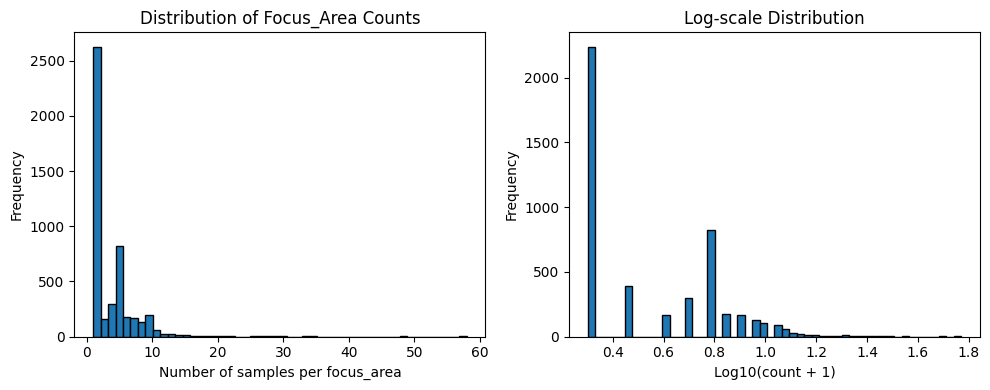

In [18]:
# TODO 3: Build unique focus_area catalog

# Get unique focus_areas with counts
cat_counts = df['focus_area_norm'].value_counts()
catalog = cat_counts.index.tolist()

print(f"✅ Catalog size: {len(catalog)} unique focus_areas")
print(f"   Total samples: {cat_counts.sum()}")
print(f"   Most common: {cat_counts.iloc[0]} ('{catalog[0]}')")
print(f"   Least common: {cat_counts.iloc[-1]} ('{catalog[-1]}')")
print(f"   Median count: {cat_counts.median():.0f}")

# Distribution of counts
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(cat_counts, bins=50, edgecolor='black')
plt.xlabel('Number of samples per focus_area')
plt.ylabel('Frequency')
plt.title('Distribution of Focus_Area Counts')

plt.subplot(1, 2, 2)
plt.hist(np.log10(cat_counts + 1), bins=50, edgecolor='black')
plt.xlabel('Log10(count + 1)')
plt.ylabel('Frequency')
plt.title('Log-scale Distribution')
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'focus_area_distribution.png', dpi=150)
plt.show()

## 🧬 Embed Focus_Areas with BioBERT

**TODO 4:** Convert focus_area strings to semantic vectors.

**Model Choice:**
- **Recommended:** `"pritamdeka/BioBERT-mnli-snli-scitail-mednli"` (medical domain)
- **Alternative:** `"all-mpnet-base-v2"` (general, strong performance)

**Why embeddings?**
- Capture semantic meaning ("Breast Cancer" ≈ "Lung Cancer" ≈ "Prostate Cancer")
- Enable clustering by similarity
- Standard NLP technique

**Hints:**
- Use `sentence-transformers` library
- Batch encode for efficiency
- **SAVE embeddings to disk** - expensive to recompute!
- Embeddings shape: `(n_catalog, embedding_dim)` e.g., `(5126, 768)`

In [19]:
# TODO 4: Embed focus_areas with BioBERT

from sentence_transformers import SentenceTransformer

# Initialize model
print("Loading embedding model...")
model = SentenceTransformer("gsarti/biobert-nli")
# # Alternative: model = SentenceTransformer("all-mpnet-base-v2")

# Encode catalog (this may take a few minutes)
print(f"Encoding {len(catalog)} focus_areas...")
embeddings = model.encode(
    catalog,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True
)

print(f"✅ Embeddings shape: {embeddings.shape}")

# Save to disk
np.save(ARTIFACTS_DIR / "catalog_embeddings.npy", embeddings)
print(f"✅ Saved embeddings to {ARTIFACTS_DIR / 'catalog_embeddings.npy'}")

# # Load embeddings (for future runs)
embeddings = np.load(ARTIFACTS_DIR / "catalog_embeddings.npy")

Loading embedding model...


No sentence-transformers model found with name gsarti/biobert-nli. Creating a new one with mean pooling.


Encoding 4742 focus_areas...


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

✅ Embeddings shape: (4742, 768)
✅ Saved embeddings to ../artifacts/specialty_taxonomy/catalog_embeddings.npy


## 📉 Dimensionality Reduction: UMAP for Visualization

**TODO 5:** Reduce embeddings to 2D for visualization (optional but highly recommended).

**Why UMAP?**
- Visualize cluster structure before clustering
- Spot natural groupings and outliers
- Helps tune clustering hyperparameters
- Beautiful plots!

**Hints:**
- Use `metric='cosine'` for text embeddings
- `n_neighbors=15-30` balances local/global structure
- Save 2D coordinates for later plotting

✅ UMAP imported successfully!
Running UMAP (this may take a few minutes)...


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP coordinates shape: (4742, 2)


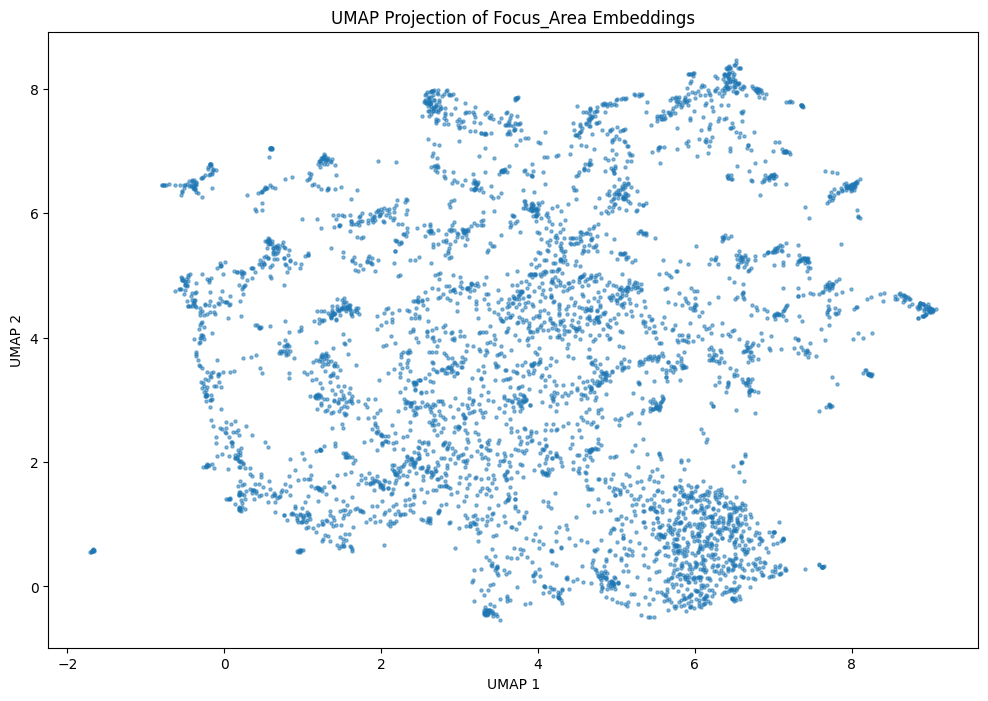

💡 Look for natural clusters/islands in the plot above!


In [20]:
# TODO 5: UMAP dimensionality reduction

import numpy as np
import matplotlib.pyplot as plt

try:
    from umap import UMAP
except (ImportError, AttributeError):
    # Newer versions expose UMAP in the umap.umap_ submodule
    from umap.umap_ import UMAP

# Test the import
print(f"✅ UMAP imported successfully!")

# Fit UMAP
print("Running UMAP (this may take a few minutes)...")
umap_model = UMAP(
    n_components=2,
    metric='cosine',
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

coords_2d = umap_model.fit_transform(embeddings)

print(f"✅ UMAP coordinates shape: {coords_2d.shape}")

# Save coordinates
np.save(ARTIFACTS_DIR / "coords_2d.npy", coords_2d)

# Quick visualization (before clustering)
plt.figure(figsize=(12, 8))
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=5, alpha=0.5)
plt.title('UMAP Projection of Focus_Area Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(ARTIFACTS_DIR / 'umap_before_clustering.png', dpi=150)
plt.show()

print("💡 Look for natural clusters/islands in the plot above!")


## 🎯 Clustering Experiment #1: HDBSCAN

**TODO 6A:** Cluster with HDBSCAN (automatically determines number of clusters).

**HDBSCAN Advantages:**
- No need to specify number of clusters
- Finds dense regions
- Labels noise points as -1
- Good for irregular cluster shapes

**Hyperparameters to tune:**
- `min_cluster_size`: Minimum samples per cluster (try 20-60)
- `min_samples`: Affects how conservative clustering is
- `metric`: 'euclidean' works well with normalized embeddings

**Hints:**
- Normalize embeddings first (L2 norm) if using euclidean metric
- Start with `min_cluster_size=40`
- Some points will be labeled as noise (-1) - that's OK!

Running HDBSCAN...


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ HDBSCAN Results:
   Number of clusters: 8
   Noise points: 4302 (90.7%)


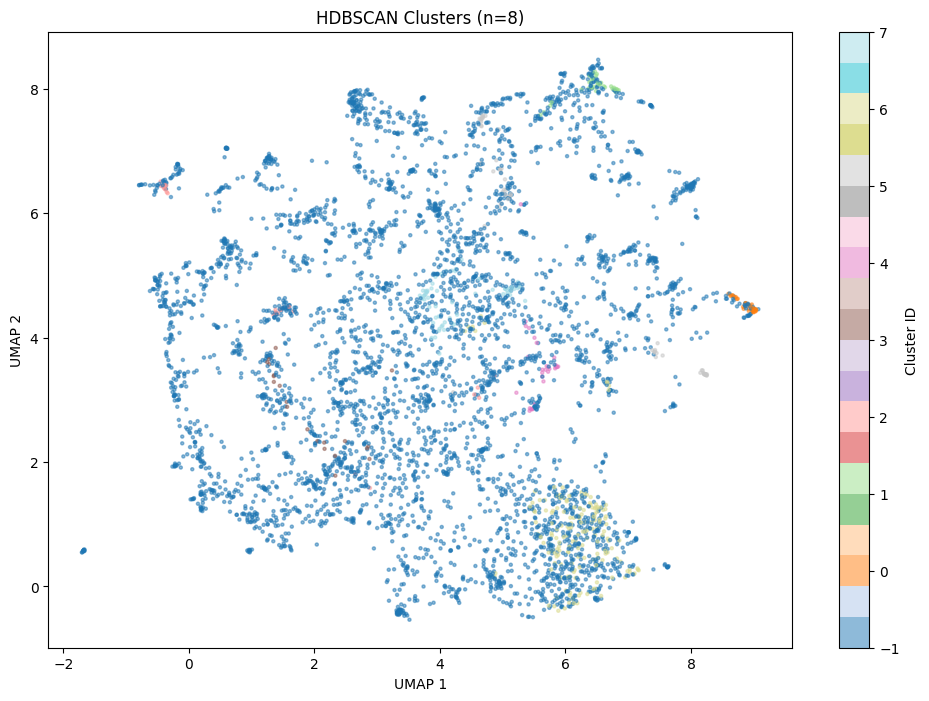

In [21]:
# TODO 6A: HDBSCAN clustering

import hdbscan
from sklearn.preprocessing import normalize

embeddings_norm = normalize(embeddings, norm='l2', axis=1)

print("Running HDBSCAN...")
clusterer_hdb = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='leaf'
)
labels_hdb = clusterer_hdb.fit_predict(embeddings_norm)

n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
n_noise = list(labels_hdb).count(-1)

print(f"\n✅ HDBSCAN Results:")
print(f"   Number of clusters: {n_clusters_hdb}")
print(f"   Noise points: {n_noise} ({100*n_noise/len(labels_hdb):.1f}%)")

np.save(ARTIFACTS_DIR / "labels_hdbscan.npy", labels_hdb)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], 
                      c=labels_hdb, s=5, alpha=0.5, cmap='tab20')
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'HDBSCAN Clusters (n={n_clusters_hdb})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(ARTIFACTS_DIR / 'hdbscan_clusters.png', dpi=150)
plt.show()

## 🎯 Clustering Experiment #2: K-Means

**TODO 6B:** Cluster with k-means (you specify number of clusters).

**K-Means Advantages:**
- Simple and fast
- Forces assignment (no noise points)
- You control number of clusters

**Choosing K:**
- Start with 30-50 clusters (fine-grained)
- Plan to merge similar clusters later
- Medical specialties typically: 15-25 major categories

**Hints:**
- Use `n_init='auto'` for automatic initialization
- Compare with HDBSCAN results
- You'll likely use k-means results (easier to label)

Running k-Means with k=18...
Initialization complete
Iteration 0, inertia 3111.025390625.
Iteration 1, inertia 2031.250732421875.
Iteration 2, inertia 1984.943115234375.
Iteration 3, inertia 1971.1456298828125.
Iteration 4, inertia 1963.590087890625.
Iteration 5, inertia 1958.886962890625.
Iteration 6, inertia 1955.64013671875.
Iteration 7, inertia 1953.889404296875.
Iteration 8, inertia 1952.5701904296875.
Iteration 9, inertia 1951.6737060546875.
Iteration 10, inertia 1950.989990234375.
Iteration 11, inertia 1950.5025634765625.
Iteration 12, inertia 1949.8533935546875.
Iteration 13, inertia 1949.253662109375.
Iteration 14, inertia 1948.730224609375.
Iteration 15, inertia 1948.2940673828125.
Iteration 16, inertia 1947.88525390625.
Iteration 17, inertia 1947.5205078125.
Iteration 18, inertia 1947.190673828125.
Iteration 19, inertia 1946.9898681640625.
Iteration 20, inertia 1946.82666015625.
Iteration 21, inertia 1946.680419921875.
Iteration 22, inertia 1946.448486328125.
Iteration 23, i

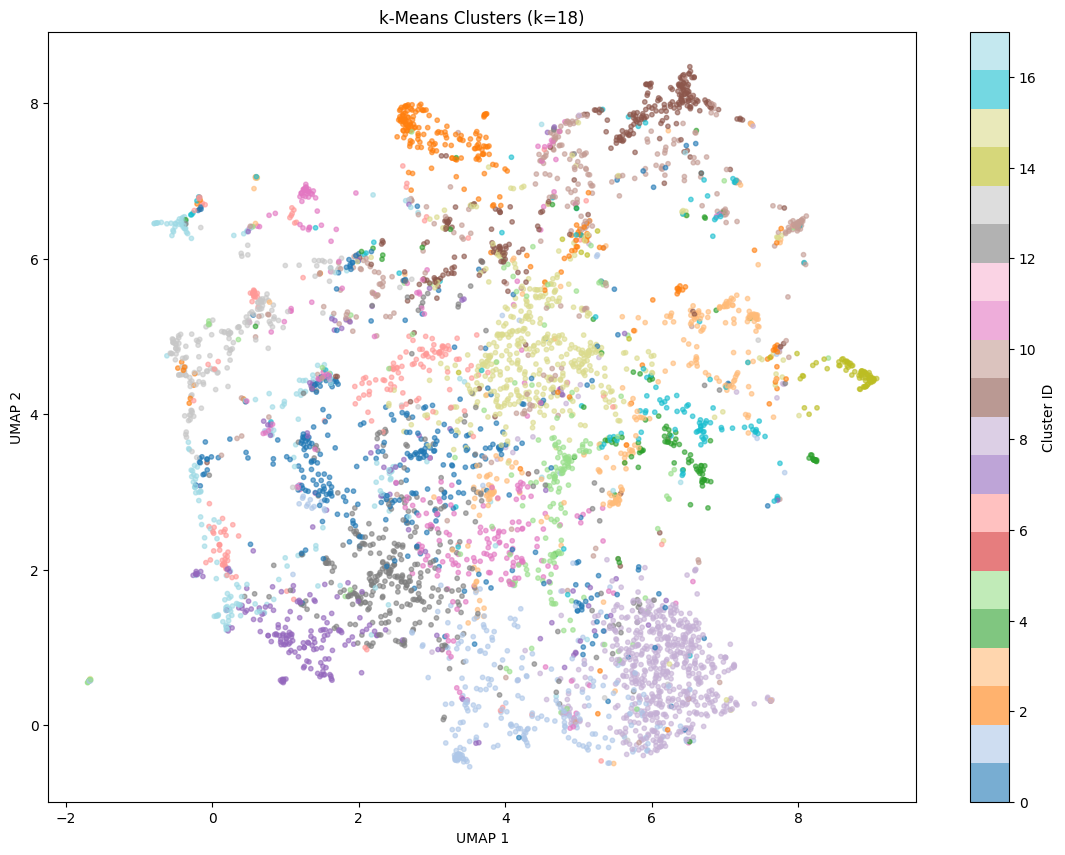

💡 Now let's see what medical terms are in each cluster...


In [22]:
# TODO 6: k-Means clustering (better for overlapping medical specialties)

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# L2 normalize embeddings
embeddings_norm = normalize(embeddings, norm='l2', axis=1)

# Try k=18 clusters (adjust between 15-20)
print("Running k-Means with k=18...")
kmeans = KMeans(
    n_clusters=18,
    random_state=42,
    n_init=10,           # Run 10 times with different initializations
    max_iter=300,
    verbose=1
)

labels_kmeans = kmeans.fit_predict(embeddings_norm)

# Results
n_clusters = len(set(labels_kmeans))
print(f"\n✅ k-Means Results:")
print(f"   Number of clusters: {n_clusters}")
print(f"   Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")

# Show cluster sizes
import pandas as pd
cluster_sizes = pd.Series(labels_kmeans).value_counts().sort_index()
print(f"\n📊 Cluster sizes:")
print(cluster_sizes)
print(f"\nSmallest cluster: {cluster_sizes.min()} labels")
print(f"Largest cluster: {cluster_sizes.max()} labels")
print(f"Average cluster size: {cluster_sizes.mean():.0f} labels")

# Save labels
np.save(ARTIFACTS_DIR / "labels_kmeans_k18.npy", labels_kmeans)

# Visualize
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    coords_2d[:, 0], 
    coords_2d[:, 1], 
    c=labels_kmeans, 
    s=10, 
    alpha=0.6, 
    cmap='tab20'
)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'k-Means Clusters (k={n_clusters})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(ARTIFACTS_DIR / 'kmeans_k18_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 Now let's see what medical terms are in each cluster...")

k=12 | Inertia: 2014.78
k=14 | Inertia: 1981.74
k=16 | Inertia: 1959.93
k=18 | Inertia: 1930.20
k=20 | Inertia: 1908.01
k=22 | Inertia: 1887.01
k=24 | Inertia: 1865.07


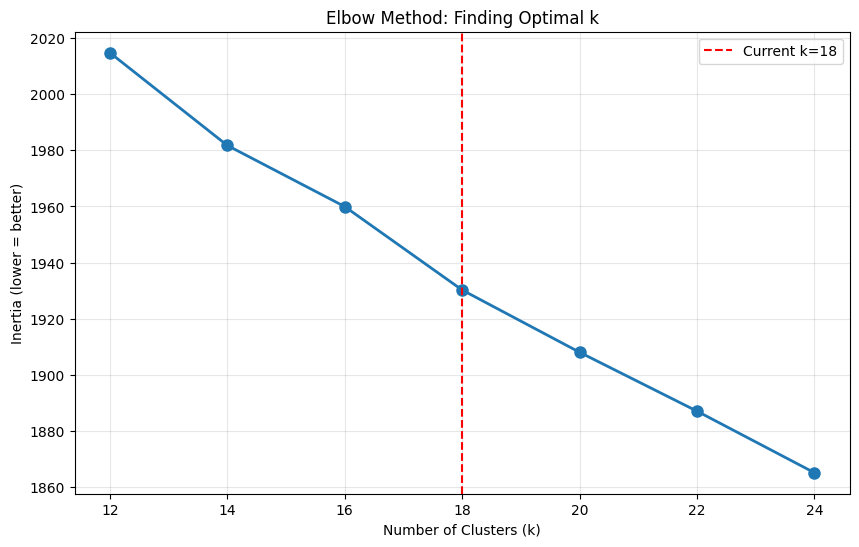


💡 Look for the 'elbow' where inertia stops dropping sharply


In [23]:
# Compare different k values
inertias = []
k_range = range(12, 26, 2)  # Test k = 12, 14, 16, 18, 20, 22, 24

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(embeddings_norm)
    inertias.append(kmeans_test.inertia_)
    print(f"k={k:2d} | Inertia: {kmeans_test.inertia_:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.axvline(x=18, color='red', linestyle='--', label='Current k=18')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (lower = better)')
plt.title('Elbow Method: Finding Optimal k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(ARTIFACTS_DIR / 'elbow_curve.png', dpi=150)
plt.show()

print("\n💡 Look for the 'elbow' where inertia stops dropping sharply")

In [25]:
# Create the correctly deduplicated list
unique_focus_areas = df['focus_area'].str.strip().str.lower().unique()

print(f"✅ Unique focus_areas (lowercased): {len(unique_focus_areas)}")
print(f"✅ Cluster labels: {len(labels_kmeans)}")
print(f"✅ UMAP coords: {coords_2d.shape[0]}")

# Verify they all match
assert len(unique_focus_areas) == len(labels_kmeans) == coords_2d.shape[0], "Mismatch!"

print("\n✅ All arrays match! Creating catalog_df...")

# Create the catalog DataFrame
catalog_df = pd.DataFrame({
    'focus_area': unique_focus_areas,
    'cluster': labels_kmeans,
    'umap_x': coords_2d[:, 0],
    'umap_y': coords_2d[:, 1]
})

print(f"\n✅ Successfully created catalog_df with {len(catalog_df)} rows!")

# Show first few rows
print(f"\n📋 First 10 rows of catalog_df:")
print(catalog_df.head(10))

# Show cluster distribution
print(f"\n📊 Cluster distribution:")
print(catalog_df['cluster'].value_counts().sort_index())

# Save for future use
catalog_df.to_csv(ARTIFACTS_DIR / 'focus_area_catalog.csv', index=False)
print(f"\n💾 Saved catalog to: {ARTIFACTS_DIR / 'focus_area_catalog.csv'}")

✅ Unique focus_areas (lowercased): 4742
✅ Cluster labels: 4742
✅ UMAP coords: 4742

✅ All arrays match! Creating catalog_df...

✅ Successfully created catalog_df with 4742 rows!

📋 First 10 rows of catalog_df:
                     focus_area  cluster    umap_x    umap_y
0                      glaucoma       13 -0.357266  3.769946
1           high blood pressure       13 -0.457261  4.503143
2       paget's disease of bone       12  2.757959  2.756014
3      urinary tract infections       13 -0.362350  4.873088
4  alcohol use and older adults       13 -0.194296  4.932808
5                osteoarthritis       11  4.956282  0.052684
6           problems with taste       13 -0.381522  4.547500
7             anxiety disorders       17  2.415400  2.754940
8                      diabetes       10  1.868660  5.192995
9  medicare and continuing care       12  2.444059  2.780257

📊 Cluster distribution:
cluster
0     349
1     272
2     235
3     267
4     110
5     196
6     181
7     229
8     

In [26]:


# You should have these variables already:
# - unique_focus_areas (or similar) - the list of unique focus_area strings
# - labels_kmeans - the cluster assignments from k-means
# - coords_2d - the UMAP coordinates (optional but useful)

# If you don't have unique_focus_areas, extract it from your original dataframe
# Assuming your original dataframe is called 'df' with a 'focus_area' column

print(f"Number of unique focus_areas: {len(unique_focus_areas)}")
print(f"Number of cluster labels: {len(labels_kmeans)}")

# Verify they match
assert len(unique_focus_areas) == len(labels_kmeans), "Mismatch in array lengths!"

# Create the catalog DataFrame
catalog_df = pd.DataFrame({
    'focus_area': unique_focus_areas,
    'cluster': labels_kmeans,
    'umap_x': coords_2d[:, 0],
    'umap_y': coords_2d[:, 1]
})

print(f"\n✅ Created catalog_df with {len(catalog_df)} rows")
print(f"\nFirst few rows:")
print(catalog_df.head())

# Check cluster distribution
print(f"\nCluster distribution:")
print(catalog_df['cluster'].value_counts().sort_index())


for cluster_id in range(18):
    cluster_terms = catalog_df[catalog_df['cluster'] == cluster_id]['focus_area'].values
    
    print(f"\n{'='*70}")
    print(f"🏷️  CLUSTER {cluster_id} | Size: {len(cluster_terms)}")
    print(f"{'='*70}")
    
    # Show 8-10 random examples
    samples = np.random.choice(cluster_terms, size=min(10, len(cluster_terms)), replace=False)
    for term in samples:
        print(f"  • {term}")
    
    # Extract common keywords
    all_words = ' '.join(cluster_terms).lower()
    from collections import Counter
    words = [w for w in all_words.split() if len(w) > 3]
    common = Counter(words).most_common(5)
    print(f"\n  🔑 Top keywords: {', '.join([w for w, c in common])}")

Number of unique focus_areas: 4742
Number of cluster labels: 4742

✅ Created catalog_df with 4742 rows

First few rows:
                     focus_area  cluster    umap_x    umap_y
0                      glaucoma       13 -0.357266  3.769946
1           high blood pressure       13 -0.457261  4.503143
2       paget's disease of bone       12  2.757959  2.756014
3      urinary tract infections       13 -0.362350  4.873088
4  alcohol use and older adults       13 -0.194296  4.932808

Cluster distribution:
cluster
0     349
1     272
2     235
3     267
4     110
5     196
6     181
7     229
8     623
9     293
10    321
11    261
12    365
13    178
14     82
15    448
16    133
17    199
Name: count, dtype: int64

🏷️  CLUSTER 0 | Size: 349
  • acrorenal mandibular syndrome
  • what i need to know about interstitial cystitis/painful bladder syndrome
  • multifocal motor neuropathy
  • joubert syndrome 2
  • mecp2 duplication syndrome
  • pyoderma gangrenosum
  • trichothiodystrophy phot

In [27]:
# Manual specialty labeling based on cluster inspection

cluster_to_specialty = {
    # Genetic/Rare Diseases (many clusters fall here)
    0: "Genetic & Rare Diseases",
    1: "Genetic & Rare Diseases", 
    2: "Neurology & Neuromuscular Disorders",
    4: "Genetic & Rare Diseases",
    7: "Genetic & Rare Diseases",
    9: "Genetic & Rare Diseases",
    
    # Specialty-specific (where clearer patterns emerge)
    3: "General Medicine & Mixed Conditions",  # childbirth, lymphoma, diabetes - very mixed
    5: "Nephrology & Rheumatology",  # gout, kidney diseases
    6: "Neurology & Autonomic Disorders",  # autonomic ganglionopathy, walking problems
    8: "General Medicine & Common Conditions",  # Largest, most diverse
    10: "Pediatrics & Developmental Disorders",  # toddler health, pediatric conditions
    11: "Neurology & Movement Disorders",  # meningitis, ALS, joint disorders
    12: "Immunology & Hematology",  # autoimmune, blood disorders
    13: "Infectious Diseases & Oncology",  # parasites, cancer
    14: "Miscellaneous & Ethics",  # Very mixed small cluster
    15: "Metabolic & Kidney Disorders",  # metabolic diseases, kidney conditions
    16: "Gastroenterology & Infectious Diseases",  # dengue, ulcerative colitis
    17: "Neurology & Genetic Disorders",  # Charcot-Marie-Tooth, genetic
}

# Apply to catalog
catalog_df['specialty'] = catalog_df['cluster'].map(cluster_to_specialty)

# Check distribution
print("\n📊 Specialty Distribution:")
print(catalog_df['specialty'].value_counts())


📊 Specialty Distribution:
specialty
Genetic & Rare Diseases                   1253
General Medicine & Common Conditions       623
Metabolic & Kidney Disorders               448
Immunology & Hematology                    365
Pediatrics & Developmental Disorders       321
General Medicine & Mixed Conditions        267
Neurology & Movement Disorders             261
Neurology & Neuromuscular Disorders        235
Neurology & Genetic Disorders              199
Nephrology & Rheumatology                  196
Neurology & Autonomic Disorders            181
Infectious Diseases & Oncology             178
Gastroenterology & Infectious Diseases     133
Miscellaneous & Ethics                      82
Name: count, dtype: int64


In [29]:
# Use whichever mapping you prefer
catalog_df['specialty'] = catalog_df['cluster'].map(cluster_to_specialty)

# Save
catalog_df.to_csv(ARTIFACTS_DIR / 'focus_area_catalog_with_specialty.csv', index=False)

In [30]:
# Clean the original df
df['focus_area_clean'] = df['focus_area'].str.strip().str.lower()

# Merge specialty labels
df_final = df.merge(
    catalog_df[['focus_area', 'specialty']],
    left_on='focus_area_clean',
    right_on='focus_area',
    how='left',
    suffixes=('', '_catalog')
)

# Check coverage
print(f"✅ Labeled {df_final['specialty'].notna().sum()} / {len(df_final)} rows")
print(f"   ({df_final['specialty'].notna().mean()*100:.1f}% coverage)")

# Show final distribution
print("\n📊 Final Dataset Distribution by Specialty:")
print(df_final['specialty'].value_counts())

# Save
df_final.to_csv(ARTIFACTS_DIR / 'medquad_with_specialties.csv', index=False)
print(f"\n💾 Saved labeled dataset!")

✅ Labeled 16398 / 16398 rows
   (100.0% coverage)

📊 Final Dataset Distribution by Specialty:
specialty
Genetic & Rare Diseases                   4066
General Medicine & Common Conditions      2192
Metabolic & Kidney Disorders              1707
Immunology & Hematology                   1174
Pediatrics & Developmental Disorders      1130
Neurology & Neuromuscular Disorders        904
General Medicine & Mixed Conditions        868
Neurology & Movement Disorders             867
Nephrology & Rheumatology                  750
Neurology & Genetic Disorders              737
Infectious Diseases & Oncology             634
Neurology & Autonomic Disorders            589
Gastroenterology & Infectious Diseases     510
Miscellaneous & Ethics                     270
Name: count, dtype: int64

💾 Saved labeled dataset!


## 🔍 Inspect Clusters: Build Summary Table

**TODO 7:** Create a DataFrame with cluster assignments and inspect each cluster.

**What to inspect:**
- Top 50 most frequent focus_areas per cluster
- Total samples per cluster
- Look for common themes (cancer types, heart conditions, eye diseases, etc.)

**Decision:** Choose which clustering to use (HDBSCAN or k-means)
- **Recommendation:** Start with k-means (easier to assign all points)

**Hints:**
- Create a catalog DataFrame: `[focus_area, count, cluster_label, coords_2d]`
- Loop through clusters and display top members
- Save per-cluster CSVs for detailed review

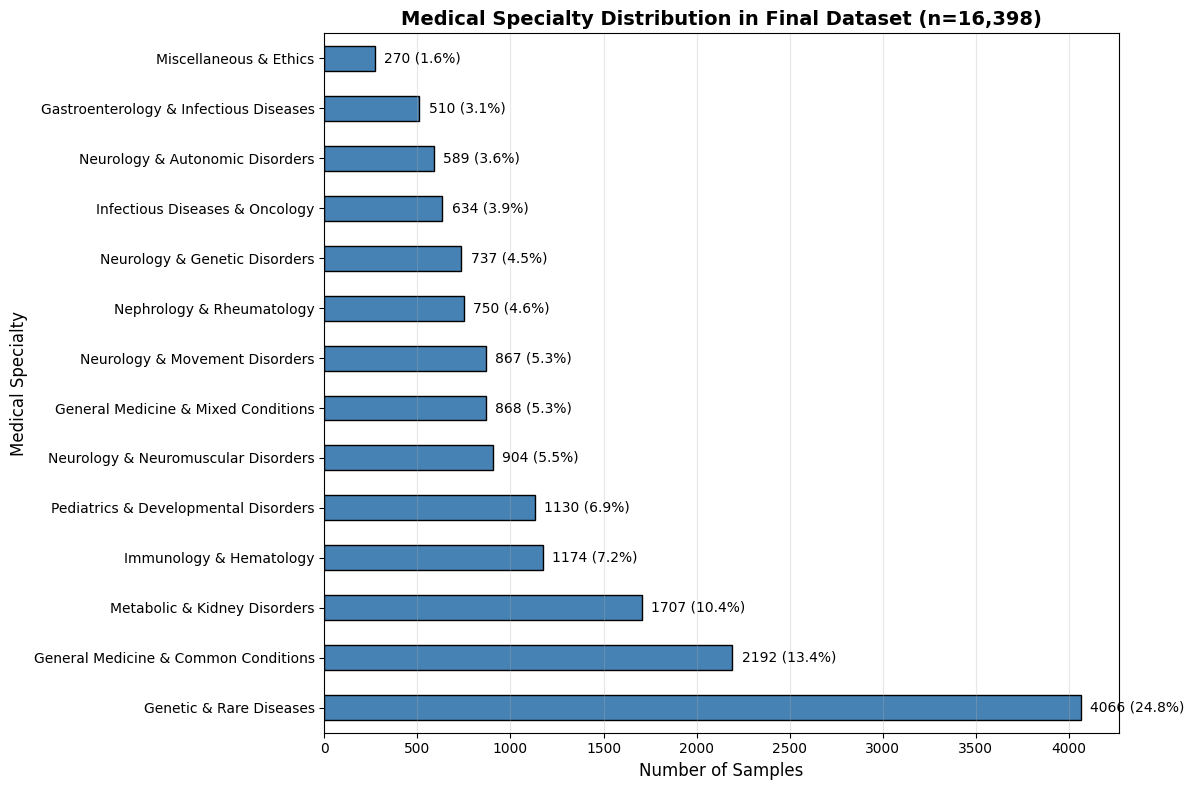

📊 Distribution summary:
   Total samples: 16,398
   Specialties: 14
   Largest class: 4,066 (24.8%)
   Smallest class: 270 (1.6%)
   Imbalance ratio: 15.1x
   Mean samples per specialty: 1171
   Median samples per specialty: 868


In [31]:
# Visualize specialty distribution

import matplotlib.pyplot as plt
import seaborn as sns

specialty_counts = df_final['specialty'].value_counts()

# Create horizontal bar chart (easier to read long labels)
plt.figure(figsize=(12, 8))
specialty_counts.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Medical Specialty', fontsize=12)
plt.title('Medical Specialty Distribution in Final Dataset (n=16,398)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add sample counts on bars
for i, (specialty, count) in enumerate(specialty_counts.items()):
    plt.text(count + 50, i, f'{count} ({count/len(df_final)*100:.1f}%)', 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'specialty_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Distribution summary:")
print(f"   Total samples: {len(df_final):,}")
print(f"   Specialties: {df_final['specialty'].nunique()}")
print(f"   Largest class: {specialty_counts.max():,} ({specialty_counts.max()/len(df_final)*100:.1f}%)")
print(f"   Smallest class: {specialty_counts.min():,} ({specialty_counts.min()/len(df_final)*100:.1f}%)")
print(f"   Imbalance ratio: {specialty_counts.max()/specialty_counts.min():.1f}x")
print(f"   Mean samples per specialty: {specialty_counts.mean():.0f}")
print(f"   Median samples per specialty: {specialty_counts.median():.0f}")

In [33]:
# Quality check: Show random samples from each specialty

print("="*80)
print("🔍 QUALITY CHECK: Random Samples from Each Specialty")
print("="*80)

for specialty in df_final['specialty'].value_counts().index[:5]:  # Check top 5
    print(f"\n{'='*80}")
    print(f"📋 {specialty}")
    print(f"{'='*80}")
    
    samples = df_final[df_final['specialty'] == specialty].sample(n=min(5, len(df_final[df_final['specialty'] == specialty])))
    
    for idx, row in samples.iterrows():
        print(f"  • Focus Area: {row['focus_area']}")
        print(f"    Question: {row['question'][:100]}...")  # First 100 chars
        print()

🔍 QUALITY CHECK: Random Samples from Each Specialty

📋 Genetic & Rare Diseases
  • Focus Area: Breast Cancer
    Question: Who is at risk for Breast Cancer? ?...

  • Focus Area: Cataract
    Question: Who is at risk for Cataract? ?...

  • Focus Area: Autosomal dominant nocturnal frontal lobe epilepsy
    Question: What is (are) Autosomal dominant nocturnal frontal lobe epilepsy ?...

  • Focus Area: Cholera
    Question: What is (are) Cholera ?...

  • Focus Area: Hypokalemic periodic paralysis
    Question: Is Hypokalemic periodic paralysis inherited ?...


📋 General Medicine & Common Conditions
  • Focus Area: Wilson-Turner syndrome
    Question: What are the symptoms of Wilson-Turner syndrome ?...

  • Focus Area: Deep Brain Stimulation for Parkinson's Disease
    Question: What is (are) Deep Brain Stimulation for Parkinson's Disease ?...

  • Focus Area: familial pityriasis rubra pilaris
    Question: What is (are) familial pityriasis rubra pilaris ?...

  • Focus Area: Hemochrom

In [ ]:
# Quality check: Show random samples from each specialty

print("="*80)
print("🔍 QUALITY CHECK: Random Samples from Each Specialty")
print("="*80)

for specialty in df_final['specialty'].value_counts().index[:5]:  # Check top 5
    print(f"\n{'='*80}")
    print(f"📋 {specialty}")
    print(f"{'='*80}")
    
    samples = df_final[df_final['specialty'] == specialty].sample(n=min(5, len(df_final[df_final['specialty'] == specialty])))
    
    for idx, row in samples.iterrows():
        print(f"  • Focus Area: {row['focus_area']}")
        print(f"    Question: {row['question'][:100]}...")  # First 100 chars
        print()

🔍 QUALITY CHECK: Random Samples from Each Specialty

📋 Genetic & Rare Diseases
  • Focus Area: Breast Cancer
    Question: Who is at risk for Breast Cancer? ?...

  • Focus Area: Cataract
    Question: Who is at risk for Cataract? ?...

  • Focus Area: Autosomal dominant nocturnal frontal lobe epilepsy
    Question: What is (are) Autosomal dominant nocturnal frontal lobe epilepsy ?...

  • Focus Area: Cholera
    Question: What is (are) Cholera ?...

  • Focus Area: Hypokalemic periodic paralysis
    Question: Is Hypokalemic periodic paralysis inherited ?...


📋 General Medicine & Common Conditions
  • Focus Area: Wilson-Turner syndrome
    Question: What are the symptoms of Wilson-Turner syndrome ?...

  • Focus Area: Deep Brain Stimulation for Parkinson's Disease
    Question: What is (are) Deep Brain Stimulation for Parkinson's Disease ?...

  • Focus Area: familial pityriasis rubra pilaris
    Question: What is (are) familial pityriasis rubra pilaris ?...

  • Focus Area: Hemochrom

## 🏷️ Manual Labeling: Assign Specialty Names to Clusters

**TODO 8:** Create a mapping from `cluster_id` → `specialty_name`.

**Common Medical Specialties:**
- **Oncology** - All cancers (breast, lung, prostate, colorectal, skin, etc.)
- **Cardiology** - Heart conditions (heart failure, heart attack, cholesterol, blood pressure)
- **Neurology** - Brain conditions (stroke, Alzheimer's, Parkinson's, headaches)
- **Ophthalmology** - Eye conditions (glaucoma, macular degeneration, cataracts)
- **Endocrinology** - Hormone/metabolic (diabetes, thyroid, obesity)
- **Pulmonology** - Lung conditions (COPD, asthma, lung cancer)
- **Gastroenterology** - Digestive system
- **Nephrology** - Kidney conditions
- **Dermatology** - Skin conditions
- **Orthopedics** - Bone/joint conditions
- **Infectious Disease** - Infections (HIV, flu, etc.)
- **Mental Health** - Psychology/psychiatry
- **General Medicine** - Primary care, preventive health
- **Other** - Miscellaneous/uncategorized

**Strategy:**
1. Start with obvious clusters (e.g., cluster with all cancers → "Oncology")
2. Merge similar small clusters (e.g., heart-related clusters → "Cardiology")
3. Create "Other" for truly mixed clusters
4. Aim for 15-20 final specialties

**Hints:**
- Iterate! This is not one-and-done
- Save mapping to JSON for reproducibility
- Document your decisions

In [ ]:
# TODO 8: Create cluster → specialty mapping

# Manual mapping based on cluster inspection above
# cluster_to_specialty = {
#     0: "Oncology",
#     1: "Cardiology",
#     2: "Neurology",
#     3: "Ophthalmology",
#     4: "Endocrinology",
#     5: "Pulmonology",
#     6: "Gastroenterology",
#     7: "Nephrology",
#     8: "Dermatology",
#     9: "Orthopedics",
#     10: "Infectious Disease",
#     11: "Mental Health",
#     12: "General Medicine",
#     # ... continue for all clusters ...
#     -1: "Other"  # For noise (if using HDBSCAN)
# }

# TODO: Fill in the mapping based on your cluster inspection!
# Inspect the output from TODO 7 above and assign meaningful names

# Save mapping
# with open(ARTIFACTS_DIR / 'cluster_to_specialty.json', 'w') as f:
#     json.dump(cluster_to_specialty, f, indent=2)

# print(f"✅ Created mapping for {len(cluster_to_specialty)} clusters")
# print(f"   Unique specialties: {len(set(cluster_to_specialty.values()))}")
# print("\nSpecialty distribution:")
# from collections import Counter
# print(Counter(cluster_to_specialty.values()))

## 🔄 Apply Specialty Labels to Catalog

**TODO 9:** Map cluster labels to specialty names in the catalog DataFrame.

**Steps:**
1. Add `specialty` column using `cluster_to_specialty` mapping
2. Handle any unmapped clusters → "Other"
3. Compute per-specialty sample counts
4. Check for class balance

**Goal:** Ensure each specialty has ≥50 samples (ideally ≥100)

**Hints:**
- Use `df['cluster'].map(cluster_to_specialty)`
- Fill missing values with "Other"
- Visualize specialty distribution

In [ ]:
# TODO 9: Apply specialty labels to catalog

# Map clusters to specialties
# catalog_df['specialty'] = catalog_df['cluster'].map(cluster_to_specialty)

# Fill any missing with "Other"
# catalog_df['specialty'] = catalog_df['specialty'].fillna('Other')

# Compute per-specialty stats
# specialty_counts = catalog_df.groupby('specialty').agg({
#     'focus_area': 'count',  # Number of unique focus_areas
#     'count': 'sum'          # Total samples
# }).rename(columns={'focus_area': 'n_unique_focus_areas', 'count': 'n_samples'})
# specialty_counts = specialty_counts.sort_values('n_samples', ascending=False)

# print("\n📊 Specialty Distribution:")
# print(specialty_counts)

# Check minimum samples
# min_samples = specialty_counts['n_samples'].min()
# print(f"\n✅ Minimum samples per specialty: {min_samples}")
# if min_samples < 50:
#     print("⚠️  Warning: Some specialties have <50 samples. Consider merging!")

# Save catalog with specialties
# catalog_df.to_csv(ARTIFACTS_DIR / 'catalog_with_specialty.csv', index=False)

# Visualize distribution
# plt.figure(figsize=(12, 6))
# specialty_counts['n_samples'].plot(kind='bar')
# plt.title('Samples per Specialty')
# plt.xlabel('Specialty')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=45, ha='right')
# plt.axhline(y=100, color='r', linestyle='--', label='Target: 100 samples')
# plt.legend()
# plt.tight_layout()
# plt.savefig(ARTIFACTS_DIR / 'specialty_distribution.png', dpi=150)
# plt.show()

## 🔄 Merge Specialty Mapping Back to Full DataFrame

**TODO 10:** Expand the focus_area → specialty mapping to all 16k+ rows.

**Steps:**
1. Merge `df` with `catalog_df` on `focus_area_norm`
2. Every row now has a `specialty` column
3. Verify no missing specialties (or fill with "Other")
4. Save the enriched dataframe

**Hints:**
- Use a left join to keep all original rows
- Check for any NaN specialties
- Save as parquet for efficiency

In [ ]:
# TODO 10: Merge specialty labels back to full dataframe

# Select columns to merge
# mapping_df = catalog_df[['focus_area', 'specialty', 'cluster']]

# Merge
# df = df.merge(
#     mapping_df,
#     left_on='focus_area_norm',
#     right_on='focus_area',
#     how='left',
#     suffixes=('', '_mapped')
# )

# # Drop duplicate focus_area column if created
# if 'focus_area_mapped' in df.columns:
#     df = df.drop(columns=['focus_area_mapped'])

# # Check for missing specialties
# missing_specialty = df['specialty'].isna().sum()
# if missing_specialty > 0:
#     print(f"⚠️  Warning: {missing_specialty} rows missing specialty. Filling with 'Other'.")
#     df['specialty'] = df['specialty'].fillna('Other')

# print(f"\n✅ Full dataframe shape: {df.shape}")
# print(f"   Columns: {list(df.columns)}")

# # Verify specialty distribution
# print("\n📊 Final specialty distribution:")
# print(df['specialty'].value_counts())

# # Save enriched dataframe
# df.to_parquet(ARTIFACTS_DIR / 'df_with_specialty.parquet', index=False)
# print(f"\n✅ Saved enriched dataframe to {ARTIFACTS_DIR / 'df_with_specialty.parquet'}")

## ✅ Validate with Zero-Shot Classification (Optional but Recommended)

**TODO 11:** Use zero-shot classification as a second opinion.

**Why zero-shot validation?**
- Independent check on your manual labeling
- Flags potential misclassifications
- Identifies ambiguous cases

**Approach:**
1. Sample 200-500 focus_areas
2. Run zero-shot classifier with your specialty list as candidates
3. Compare `specialty` (from clustering) vs. zero-shot prediction
4. Inspect disagreements

**Hints:**
- Use `microsoft/deberta-v3-large-mnli` (strong zero-shot model)
- Focus on high-count focus_areas (more important to get right)
- This is slow - run on a sample!

In [ ]:
# TODO 11: Zero-shot validation (optional)

# from transformers import pipeline

# # Initialize zero-shot classifier
# print("Loading zero-shot classifier (this may take a minute)...")
# zero_shot_clf = pipeline(
#     "zero-shot-classification",
#     model="microsoft/deberta-v3-large-mnli"
# )

# # Get unique specialties
# candidate_labels = sorted(catalog_df['specialty'].unique())
# print(f"\nCandidate specialties: {candidate_labels}")

# # Sample focus_areas for validation (prioritize high-count ones)
# sample_df = catalog_df.nlargest(200, 'count').copy()

# # Run zero-shot classification
# print(f"\nRunning zero-shot on {len(sample_df)} focus_areas...")
# zero_shot_predictions = []
# for idx, row in sample_df.iterrows():
#     result = zero_shot_clf(
#         row['focus_area'],
#         candidate_labels=candidate_labels,
#         multi_label=False
#     )
#     zero_shot_predictions.append(result['labels'][0])  # Top prediction

# sample_df['zero_shot_specialty'] = zero_shot_predictions

# # Compare with cluster-based specialty
# sample_df['agreement'] = sample_df['specialty'] == sample_df['zero_shot_specialty']
# agreement_rate = sample_df['agreement'].mean()

# print(f"\n✅ Agreement rate: {agreement_rate:.1%}")

# # Show disagreements
# disagreements = sample_df[~sample_df['agreement']].sort_values('count', ascending=False)
# print(f"\n⚠️  Disagreements ({len(disagreements)}):")
# print(disagreements[['focus_area', 'count', 'specialty', 'zero_shot_specialty']].head(20))

# # Save validation results
# sample_df.to_csv(ARTIFACTS_DIR / 'zero_shot_validation.csv', index=False)

## 📊 Final Quality Checks & Balance Analysis

**TODO 12:** Assess the final specialty distribution and decide on any final adjustments.

**Quality Checks:**
1. **Minimum samples:** Every specialty should have ≥50 samples
2. **Class balance:** Largest/smallest ratio should be <50:1
3. **Number of classes:** Should be 15-25 (too few = loss of granularity, too many = data scarcity)

**If problems exist:**
- Merge rare specialties into "Other" or related specialties
- Split very large specialties if semantically distinct

**Hints:**
- Create a threshold function to group rare classes
- Document any merging decisions

In [ ]:
# TODO 12: Final quality checks and balance

# Compute final stats
# specialty_final = df['specialty'].value_counts().sort_values(ascending=False)
# n_specialties = len(specialty_final)
# min_samples = specialty_final.min()
# max_samples = specialty_final.max()
# imbalance_ratio = max_samples / min_samples

# print("📊 Final Taxonomy Stats:")
# print(f"   Number of specialties: {n_specialties}")
# print(f"   Total samples: {len(df)}")
# print(f"   Min samples per specialty: {min_samples}")
# print(f"   Max samples per specialty: {max_samples}")
# print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")

# print("\nPer-specialty counts:")
# print(specialty_final)

# # Check acceptance criteria
# print("\n✅ Acceptance Criteria Check:")
# print(f"   ✓ Min samples ≥50? {min_samples >= 50}")
# print(f"   ✓ Number of classes 15-25? {15 <= n_specialties <= 25}")
# print(f"   ✓ Imbalance ratio <50:1? {imbalance_ratio < 50}")

# # Optional: Apply minimum sample threshold
# MIN_SAMPLES = 50
# rare_specialties = specialty_final[specialty_final < MIN_SAMPLES].index.tolist()
# if rare_specialties:
#     print(f"\n⚠️  Rare specialties (<{MIN_SAMPLES} samples): {rare_specialties}")
#     print("   Consider merging these into 'Other' or related specialties.")
#     # df.loc[df['specialty'].isin(rare_specialties), 'specialty'] = 'Other'

# # Visualize final distribution
# plt.figure(figsize=(14, 6))
# specialty_final.plot(kind='barh')
# plt.xlabel('Number of Samples')
# plt.ylabel('Specialty')
# plt.title(f'Final Specialty Distribution (n={n_specialties} classes)')
# plt.axvline(x=100, color='g', linestyle='--', label='Target: 100+')
# plt.axvline(x=50, color='r', linestyle='--', label='Minimum: 50')
# plt.legend()
# plt.tight_layout()
# plt.savefig(ARTIFACTS_DIR / 'final_specialty_distribution.png', dpi=150)
# plt.show()

## 💾 Export Final Taxonomy & Metadata

**TODO 13:** Save all artifacts for use in downstream notebooks.

**What to export:**
1. `df_with_specialty.parquet` - Full dataframe with specialty column
2. `focus_area_to_specialty.json` - Direct mapping for quick lookup
3. `taxonomy_metadata.json` - Document all decisions and parameters
4. Summary README

**Hints:**
- Include clustering parameters in metadata
- Note any manual merging decisions
- Record date and model versions

In [ ]:
# TODO 13: Export final taxonomy and metadata

# 1. Create focus_area → specialty mapping
# focus_area_to_specialty = catalog_df.set_index('focus_area')['specialty'].to_dict()
# with open(ARTIFACTS_DIR / 'focus_area_to_specialty.json', 'w') as f:
#     json.dump(focus_area_to_specialty, f, indent=2)

# 2. Create metadata
# from datetime import datetime
# metadata = {
#     'created_date': datetime.now().isoformat(),
#     'input_data': str(INPUT_PATH),
#     'n_original_focus_areas': len(catalog),
#     'n_final_specialties': len(df['specialty'].unique()),
#     'total_samples': len(df),
#     'embedding_model': 'pritamdeka/BioBERT-mnli-snli-scitail-mednli',
#     'clustering_method': 'kmeans',  # or 'hdbscan'
#     'clustering_params': {
#         'n_clusters': 40,  # if kmeans
#         # 'min_cluster_size': 40,  # if hdbscan
#     },
#     'specialty_list': sorted(df['specialty'].unique()),
#     'per_specialty_counts': df['specialty'].value_counts().to_dict(),
#     'manual_decisions': [
#         'Merged all cancer types into Oncology',
#         'Grouped heart conditions into Cardiology',
#         # Add your decisions here
#     ]
# }
# with open(ARTIFACTS_DIR / 'taxonomy_metadata.json', 'w') as f:
#     json.dump(metadata, f, indent=2)

# 3. Create summary README
# readme_text = f"""
# # Medical Specialty Taxonomy

# **Created:** {datetime.now().strftime('%Y-%m-%d')}

# ## Summary

# - Original focus_areas: {len(catalog)}
# - Final specialties: {len(df['specialty'].unique())}
# - Total samples: {len(df)}

# ## Method

# 1. Embedded focus_area strings using BioBERT
# 2. Clustered with k-means (K=40)
# 3. Manually labeled clusters as medical specialties
# 4. Validated with zero-shot classification
# 5. Merged to full dataframe

# ## Files

# - `df_with_specialty.parquet` - Full dataframe with specialty column
# - `focus_area_to_specialty.json` - Direct mapping
# - `taxonomy_metadata.json` - Detailed metadata
# - `catalog_with_specialty.csv` - Catalog with cluster assignments

# ## Specialties

# {df['specialty'].value_counts().to_string()}
# """
# with open(ARTIFACTS_DIR / 'README.md', 'w') as f:
#     f.write(readme_text)

# print("✅ Exported all artifacts to:", ARTIFACTS_DIR)
# print("\nFiles created:")
# print("  - df_with_specialty.parquet")
# print("  - focus_area_to_specialty.json")
# print("  - taxonomy_metadata.json")
# print("  - README.md")

## 🤔 Reflection

Answer these questions after completing the taxonomy:

1. **How many final specialties did you create? Is this reasonable?**

2. **What were the hardest clustering decisions? Why?**

3. **How did zero-shot validation help (if you ran it)?**

4. **What would you do differently if starting over?**

5. **Are there any specialties you're uncertain about?**

6. **What did you learn about medical domain knowledge from this exercise?**

**Your reflections:**

*Write your answers here*

## 📌 Summary

✅ Built data-driven specialty taxonomy  
✅ Reduced 5,126 focus_areas → 15-20 specialties  
✅ Each specialty has sufficient samples  
✅ Validated with zero-shot classification  
✅ Exported artifacts for downstream use

**Next:** `01_project_scope_and_data.ipynb` (now with manageable specialty categories!)

---

## 🎓 What You Learned

**NLP Skills:**
- Semantic embeddings with BioBERT
- Text clustering (HDBSCAN, k-means)
- Zero-shot classification for validation

**Data Science Skills:**
- Bottom-up taxonomy construction
- Handling extreme class imbalance (5,126 classes!)
- Dimensionality reduction (UMAP)
- Cluster inspection and labeling

**Domain Skills:**
- Medical specialty categorization
- Semantic grouping of conditions
- Balancing granularity vs. data availability

**Project Management:**
- Artifact management
- Reproducible workflows
- Documentation and metadata

---

*This notebook demonstrates advanced NLP techniques for real-world data challenges. The approach is generalizable to any multi-class problem with too many fine-grained labels!*